# rBergomi Model Implementation with Fractional Brownian Motion
This notebook demonstrates the implementation and usage of the rough Bergomi (rBergomi) stochastic volatility model with different fBM methods.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from rough_bergomi.models import RoughBergomiModel, GBMModel, HestonModel
from rough_bergomi.utils.utils import bs_delta, bsinv, bs  # Black-Scholes inversion for IV calculation

from rough_bergomi.hedging.deep_hedger import DeepHedgerTF

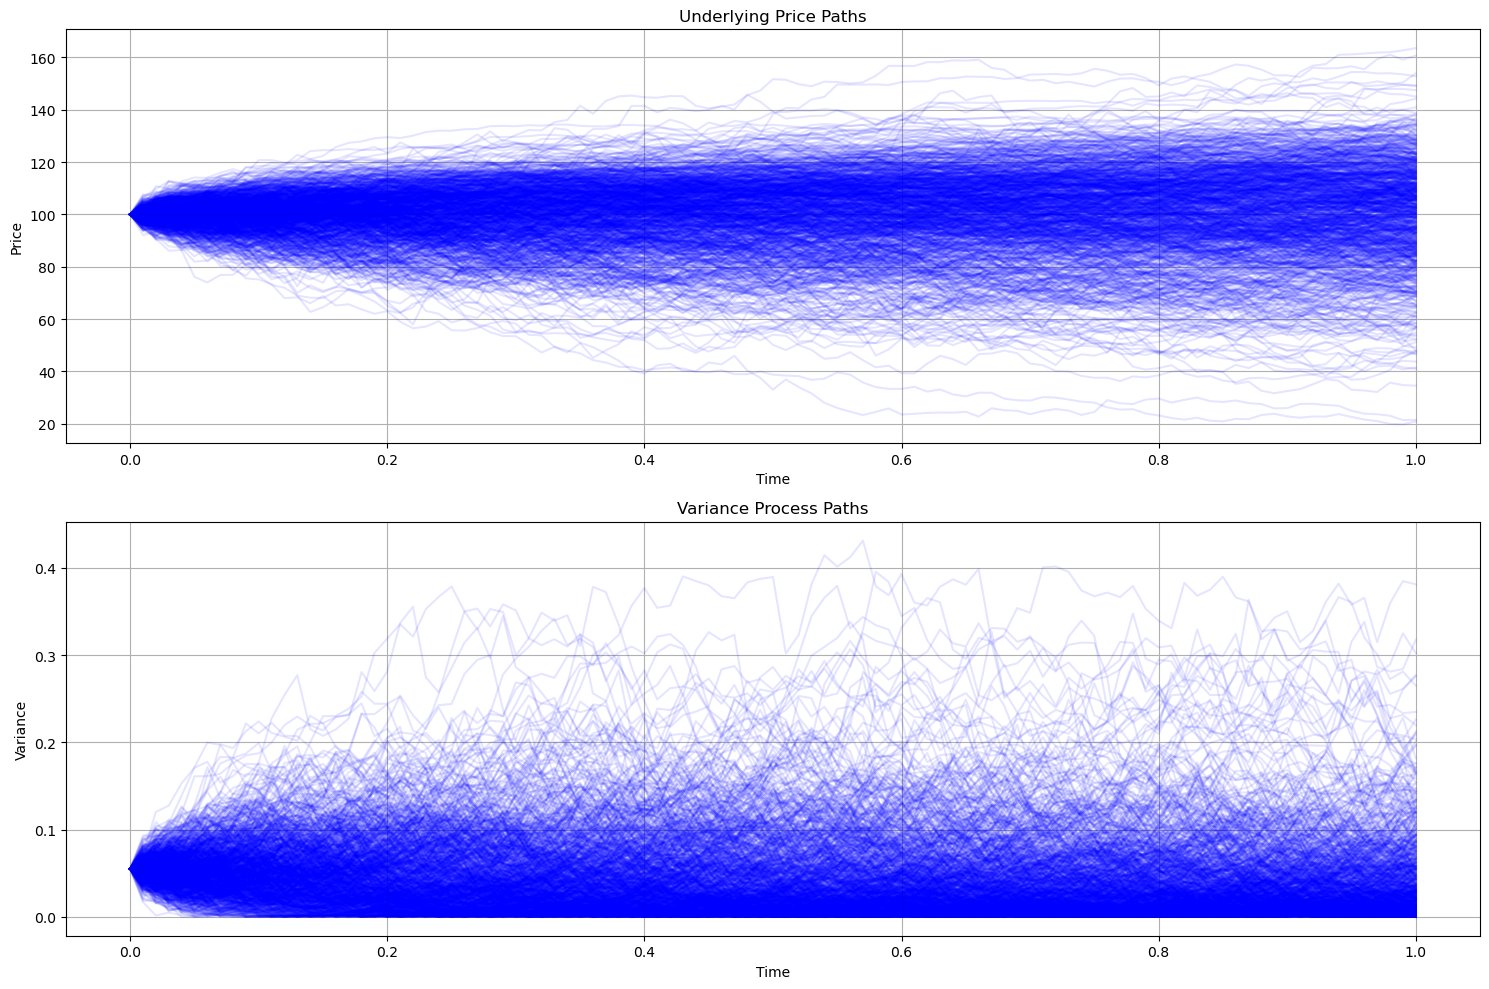

In [7]:
# Simulation parameters
T = 1.0        # Time horizon (1 year)
N = 100       # Number of time steps (daily)
M = 1000      # Number of paths
S0 = 100      # Initial stock price

model_heston = HestonModel()

# Simulate paths
S, V = model_heston.simulate_paths(n_paths=M, n_steps=N, T=T, S0=S0)

# Create time grid based on the simulation output dimensions
t = np.linspace(0, T, V.shape[1])

# Plotting
plt.figure(figsize=(15, 10))

# Plot underlying price paths
plt.subplot(2, 1, 1)
plt.plot(t, S.T, alpha=0.1, color='blue')  # Plot each path with transparency
plt.title('Underlying Price Paths')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)

# Plot variance process paths
plt.subplot(2, 1, 2)
plt.plot(t, V.T, alpha=0.1, color='blue')  # Plot each path with transparency
plt.title('Variance Process Paths')
plt.xlabel('Time')
plt.ylabel('Variance')
plt.grid(True)

plt.tight_layout()
plt.show()

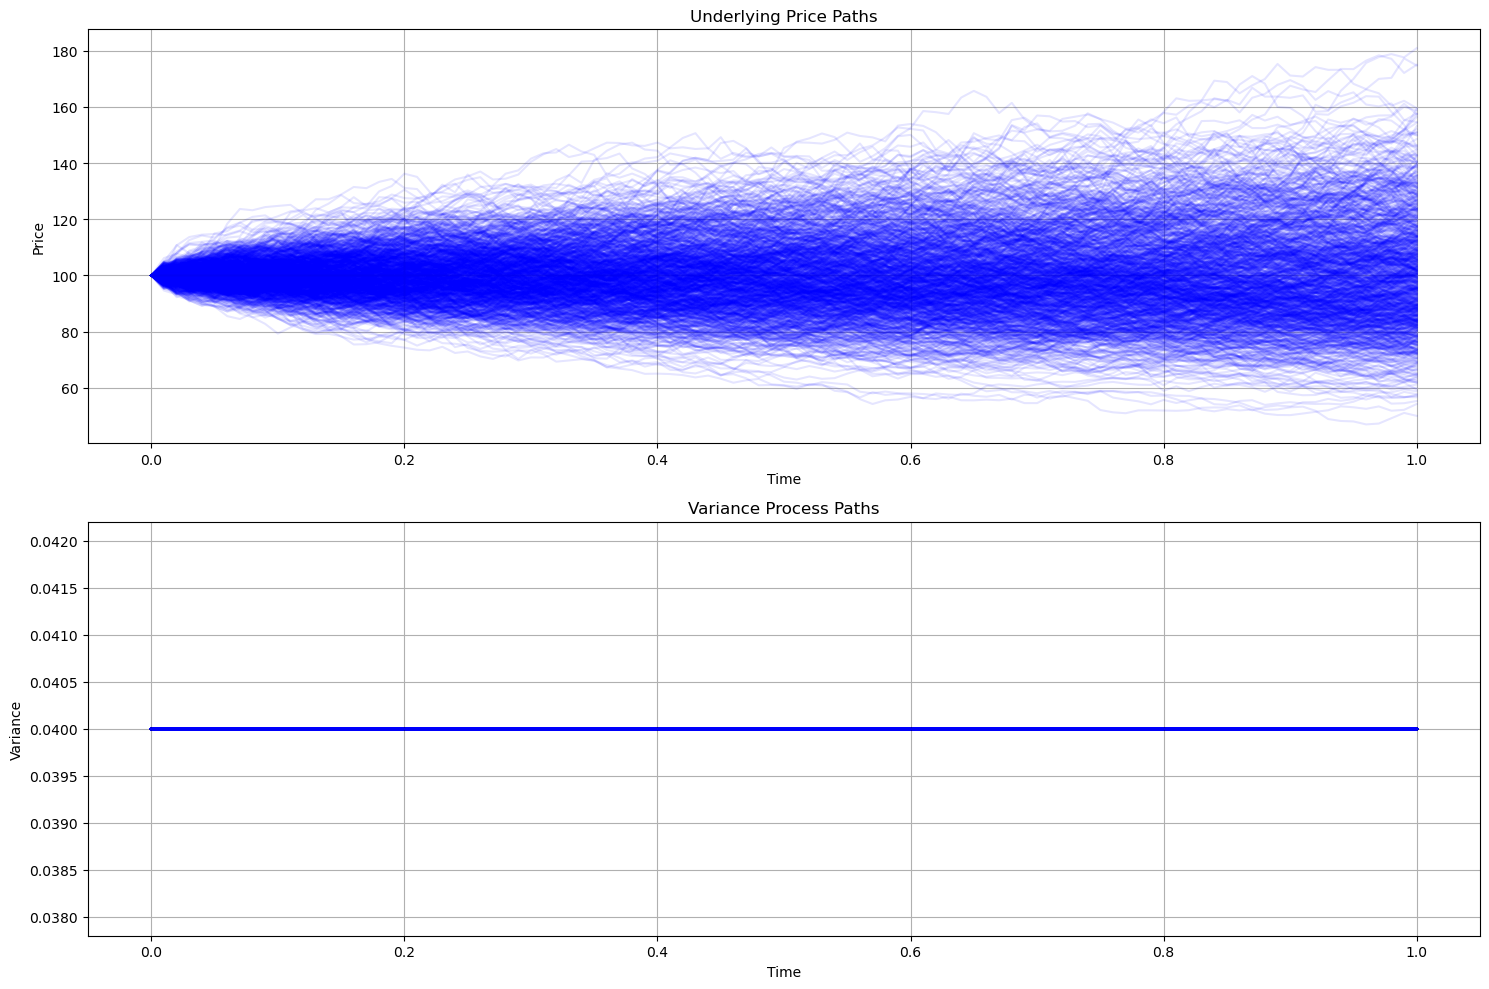

In [8]:
# Simulation parameters
T = 1.0        # Time horizon (1 year)
N = 100       # Number of time steps (daily)
M = 1000      # Number of paths
S0 = 100      # Initial stock price

model_gbm = GBMModel(mu=0, sigma=0.2)

# Simulate paths
S, V = model_gbm.simulate_paths(n_paths=M, n_steps=N, T=T, S0=S0)

# Create time grid based on the simulation output dimensions
t = np.linspace(0, T, V.shape[1])

# Plotting
plt.figure(figsize=(15, 10))

# Plot underlying price paths
plt.subplot(2, 1, 1)
plt.plot(t, S.T, alpha=0.1, color='blue')  # Plot each path with transparency
plt.title('Underlying Price Paths')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)

# Plot variance process paths
plt.subplot(2, 1, 2)
plt.plot(t, V.T, alpha=0.1, color='blue')  # Plot each path with transparency
plt.title('Variance Process Paths')
plt.xlabel('Time')
plt.ylabel('Variance')
plt.grid(True)

plt.tight_layout()
plt.show()

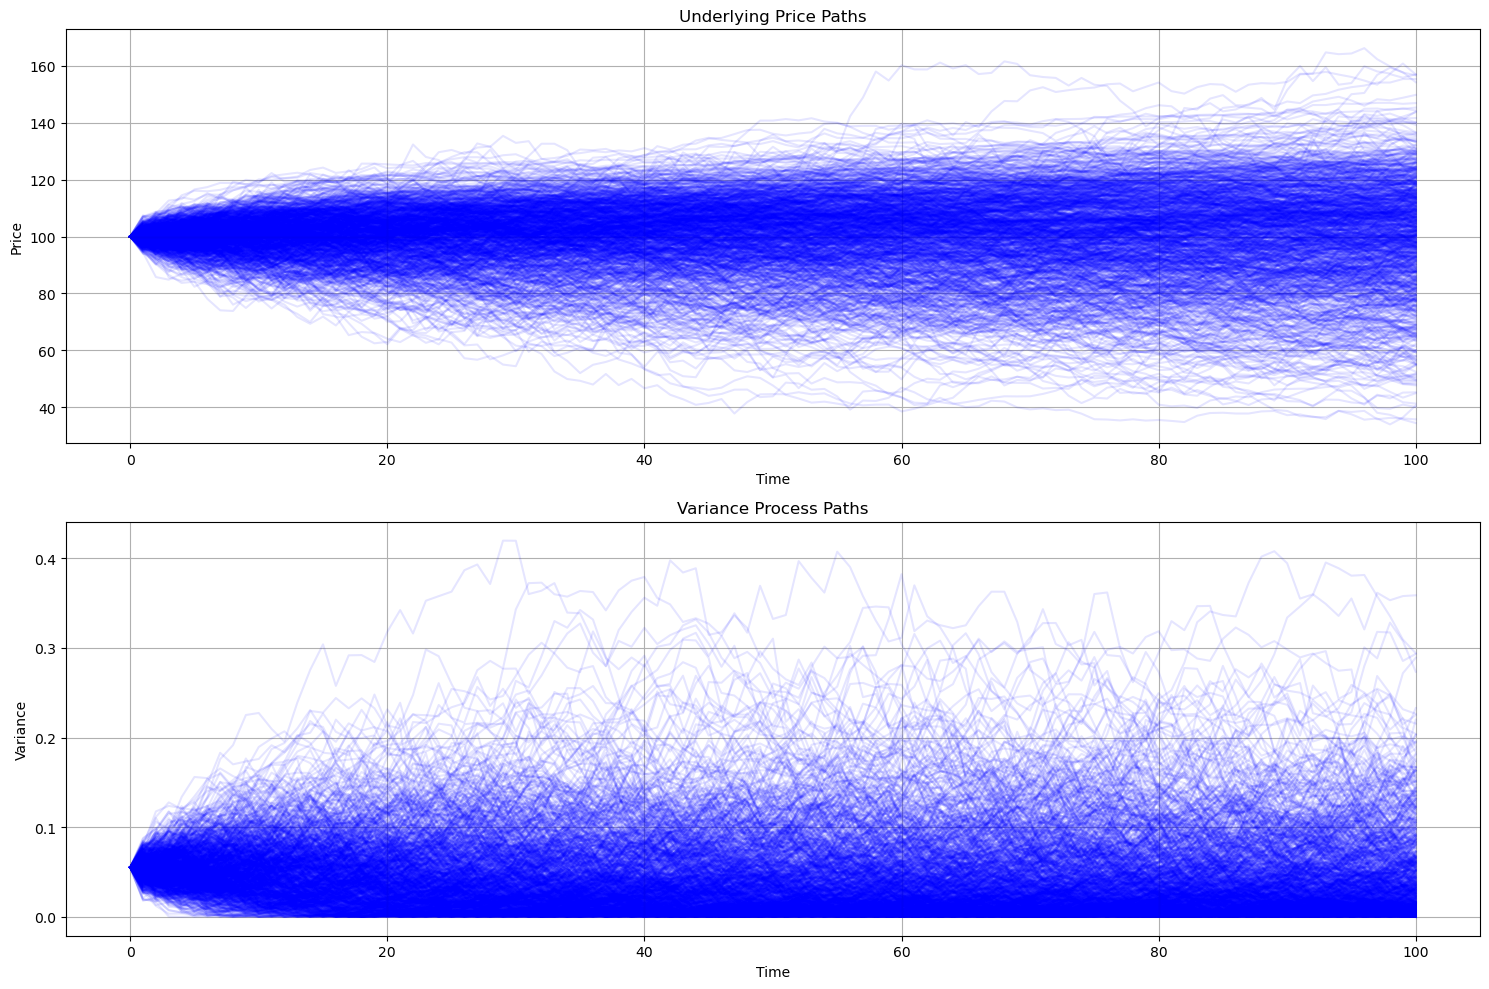

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, None, 64)       │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, None, 32)       │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 16)       │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, None, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, None, 1)        │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,817 (89.13 KB)

 Trainable params: 22,817 (89.13 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Check Model [-0.05334558 -0.05778493 -0.05921383 -0.05933492 -0.05900583 -0.05862922
 -0.05834296 -0.05816367 -0.05806653 -0.05802114 -0.0580039  -0.05799975
 -0.05800449 -0.0580086  -0.05801103 -0.05801203 -0.05801204 -0.05801149
 -0.05801069 -0.05800986 -0.05800911 -0.05800848 -0.05800797 -0.05800758
 -0.0580073  -0.0580071  -0.05800695 -0.05800685 -0.05800677 -0.05800673
 -0.0580067  -0.05800667 -0.05800666 -0.05800664 -0.05800664 -0.05800664
 -0.05800664 -0.05800664 -0.05800664 -0.05800664 -0.05800664 -0.05800663
 -0.05800664 -0.05800664 -0.05800664 -0.05800664 -0.05800664 -0.05800664
 -0.05800664 -0.05800664 -0.05800664 -0.05800664 -0.05800664 -0.05800664
 -0.05800664 -0.05800664 -0.05800664 -0.05800664 -0.05800664 -0.05800664
 -0.05800664 -0.05800664 -0.05800664 -0.05800664 -0.05800664 -0.05800664
 -0.05800664 -0.05800664 -0.05800664 -0.05800664 -0.05800664 -0.05800664
 -0.05800664 -0.05800664 -0.05800664 -0.05800664 -0.05800664 -0.05800664


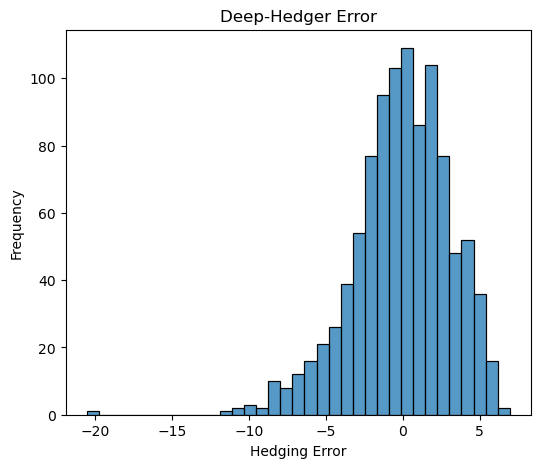

In [9]:
# Simulation parameters
T = 1.0        # Time horizon (1 year)
N = 100       # Number of time steps (daily)
M = 1000      # Number of paths

# Base model parameters
xi = 0.235**2  # Initial variance
rho = -0.9     # Correlation
eta = 1.9      # Volatility of variance
S0 = 100       # Initial price
K = 100        # Strike price
# Choose a single rough Bergomi specification
H = 0.1              # Hurst parameter
fbm_method = 'hybrid'  # fBm simulation method

model_rb = RoughBergomiModel(xi=xi, H=H, n=N, rho=rho, eta=eta, fbm_method=fbm_method)
model_gbm = GBMModel(mu=0, sigma=0.2)
model_heston = HestonModel()

# Instantiate the class
dh = DeepHedgerTF(model = model_heston, S0=S0, K_strike=K, M=M, T=T, N = N, r=0, CALL=1)

# Optionally, plot the simulated paths
dh.plot_paths()

# Prepare your data
dh.prepare_data()

# Build and compile the deep hedger model (you can choose MSHE or CVaR loss)
dh.build_and_compile_model(lr=0.005, loss_type='cvar')

# Train the model
dh.train_model(BATCH_SIZE=256, EPOCHS=50)

# Evaluate the model
error = dh.evaluate_model()

# Plot the error distribution

dh.plot_error()

In [ ]:
# Simulation parameters
T = 1.0        # Time horizon (1 year)
N = 100       # Number of time steps (daily)
M = 10000      # Number of paths

# Base model parameters
xi = 0.235**2  # Initial variance
rho = -0.9     # Correlation
eta = 1.9      # Volatility of variance
S0 = 100       # Initial price

# Choose a single rough Bergomi specification
H = 0.13              # Hurst parameter
fbm_method = 'hybrid'  # fBm simulation method

# Create a model instance with the chosen parameters
model = RoughBergomiModel(xi=xi, H=H, n=N, rho=rho, eta=eta, fbm_method=fbm_method)

# Simulate paths
S, V = model.simulate_paths(n_paths=M, n_steps=N, T=T, S0=S0)

# Create time grid based on the simulation output dimensions
t = np.linspace(0, T, V.shape[1])

# Plotting
plt.figure(figsize=(15, 10))

# Plot underlying price paths
plt.subplot(2, 1, 1)
plt.plot(t, S.T, alpha=0.1, color='blue')  # Plot each path with transparency
plt.title('Underlying Price Paths')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)

# Plot variance process paths
plt.subplot(2, 1, 2)
plt.plot(t, V.T, alpha=0.1, color='blue')  # Plot each path with transparency
plt.title('Variance Process Paths')
plt.xlabel('Time')
plt.ylabel('Variance')
plt.grid(True)

plt.tight_layout()
plt.show()

## 1. Model Setup and Path Simulation

First, let's create instances of the Rough Bergomi model with different Hurst parameters and fBM methods:

In [ ]:
# Parameters
S0 = 100      # Initial underlying price
T = 1.0       # Time to maturity
r = 0.0       # Risk-free rate
strikes = np.linspace(50, 150, 1000)  # Range of strike prices

option_prices = []
implied_vols = []

# Loop over each strike to calculate option price and implied volatility
for k in strikes:
    price = model.price_european(S, K, T, r)
    option_prices.append(price)
    
    iv = bsinv(price, S0, k, T, r)
    implied_vols.append(iv)

# Calibrate the ATM volatility using the strike closest to S0
atm_index = np.argmin(np.abs(strikes - S0))
atm_strike = strikes[atm_index]
atm_price = model.price_european(S, atm_strike, T, r)
atm_vol = bsinv(atm_price, S0, atm_strike, T, 'call')
print("Calibrated ATM volatility:", atm_vol)

# Compute Black–Scholes prices using a constant volatility (e.g., 20% annualized)
vol = atm_vol
bs_prices = []
for k in strikes:
    # Integrated variance V = sigma^2 * T
    bs_price = bs(S0, k, vol**2 * T, o='call')
    bs_prices.append(bs_price)

# Plotting the results
plt.figure(figsize=(15, 10))
plt.plot(strikes, option_prices, label='Model Price', color='blue')
plt.plot(strikes, bs_prices, label='Black–Scholes Price', color='green', linestyle='--')
plt.title('Option Price vs Strike: Model vs Black–Scholes')
plt.xlabel('Strike')
plt.ylabel('Option Price')
plt.grid(True)
plt.legend()
plt.show()

# Volatility smile: Implied Volatility vs. Strike
plt.subplot(2, 1, 2)
plt.plot(strikes, implied_vols, color='red')
plt.title('Volatility Smile')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Assume constant volatility = sqrt(xi)
sigma = np.sqrt(xi)
dt = T / N

bs_deltas = np.zeros((M, N))
bs_vals = np.zeros((M, N + 1))
bs_vals[:, 0] = dh.price

for t in range(N):
    tau = T - t * dt
    bs_deltas[:, t] = bs_delta(dh.Sts[:, t], K, T, t * dt, sigma)
    bs_vals[:, t+1] = (
        bs_vals[:, t] * dh.rf + bs_deltas[:, t] * (dh.Sts[:, t+1] - dh.rf * dh.Sts[:, t])
    )

bs_terminal_error = bs_vals[:, -1] - np.maximum(dh.Sts[:, -1] - K, 0)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.histplot(dh.deep_terminal_error, label="Deep Hedger", stat="density", bins=200, kde=True, color='blue')
sns.histplot(bs_terminal_error, label="Black-Scholes", stat="density", bins=200, kde=True, color='orange')
plt.title("Comparison of Hedging Errors")
plt.xlabel("Hedging Error")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.xlim(-20, 20)
plt.show()

In [ ]:
def summarize_errors(name, errors):
    print(f"\n{name} Hedging Error Summary:")
    print(f"Mean Error        : {np.mean(errors):.4f}")
    print(f"Standard Deviation: {np.std(errors):.4f}")
    print(f"95% CVaR          : {np.mean(np.sort(errors)[int(0.95 * len(errors)):]):.4f}")
    print(f"5% Worst Loss     : {np.min(errors):.4f}")

summarize_errors("Deep Hedger", dh.deep_terminal_error)
summarize_errors("Black-Scholes", bs_terminal_error)